In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/MyDrive/imaging/classification/

!unzip -o ./train.zip -d /content/gdrive/MyDrive/imaging/classification/train/
!unzip -o ./val.zip -d /content/gdrive/MyDrive/imaging/classification/val/
%cd /content/gdrive/MyDrive/imaging/classification/





流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/gdrive/MyDrive/imaging/classification/val/0nm2/1901.bmp  
  inflating: /content/gdrive/MyDrive/imaging/classification/val/0nm2/1902.bmp  
  inflating: /content/gdrive/MyDrive/imaging/classification/val/0nm2/1903.bmp  
  inflating: /content/gdrive/MyDrive/imaging/classification/val/0nm2/1904.bmp  
  inflating: /content/gdrive/MyDrive/imaging/classification/val/0nm2/1905.bmp  
  inflating: /content/gdrive/MyDrive/imaging/classification/val/0nm2/1906.bmp  
  inflating: /content/gdrive/MyDrive/imaging/classification/val/0nm2/1907.bmp  
  inflating: /content/gdrive/MyDrive/imaging/classification/val/0nm2/1908.bmp  
  inflating: /content/gdrive/MyDrive/imaging/classification/val/0nm2/1909.bmp  
  inflating: /content/gdrive/MyDrive/imaging/classification/val/0nm2/191.bmp  
  inflating: /content/gdrive/MyDrive/imaging/classification/val/0nm2/1910.bmp  
  inflating: /content/gdrive/MyDrive/imaging/classification/val/0nm2/1911.bmp  
  inflating: /

Epoch 0, Training Loss: 0.32013885339999454, Training Accuracy: 0.8965, Validation Loss: 0.01304874363510559, Validation Accuracy: 1.0
Epoch 1, Training Loss: 0.008157724048942327, Training Accuracy: 1.0, Validation Loss: 0.005153697216883302, Validation Accuracy: 1.0
Epoch 2, Training Loss: 0.00394048835547205, Training Accuracy: 1.0, Validation Loss: 0.002915489429142326, Validation Accuracy: 1.0
Epoch 3, Training Loss: 0.0023609008392358713, Training Accuracy: 1.0, Validation Loss: 0.0019462293760928635, Validation Accuracy: 1.0
Epoch 4, Training Loss: 0.0016381696641861283, Training Accuracy: 1.0, Validation Loss: 0.0013989947425822418, Validation Accuracy: 1.0
Epoch 5, Training Loss: 0.0012167008739816857, Training Accuracy: 1.0, Validation Loss: 0.0010675031032102804, Validation Accuracy: 1.0
Epoch 6, Training Loss: 0.0009455746330786496, Training Accuracy: 1.0, Validation Loss: 0.0008460837998427451, Validation Accuracy: 1.0
Epoch 7, Training Loss: 0.0007589516159335271, Trainin

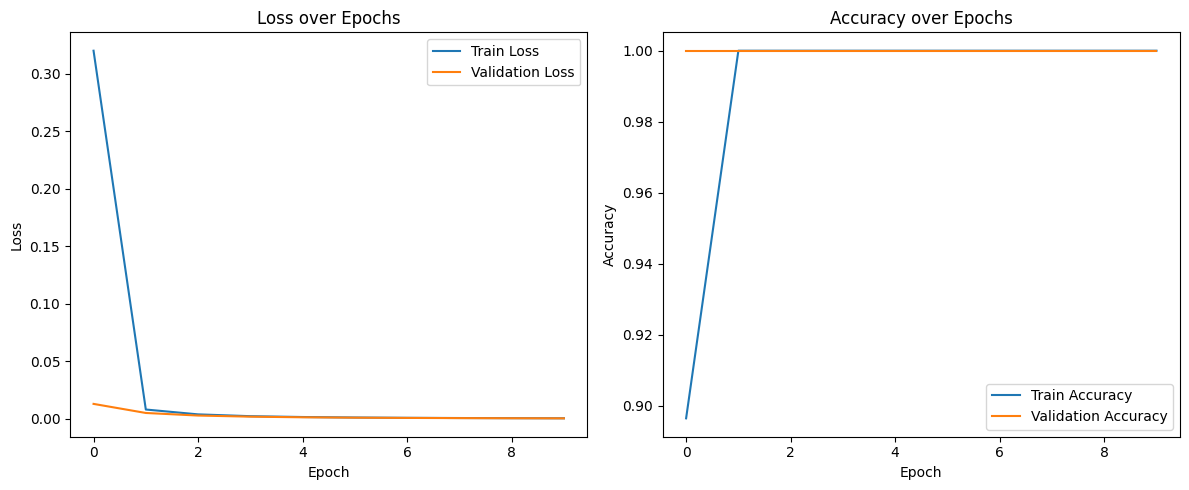

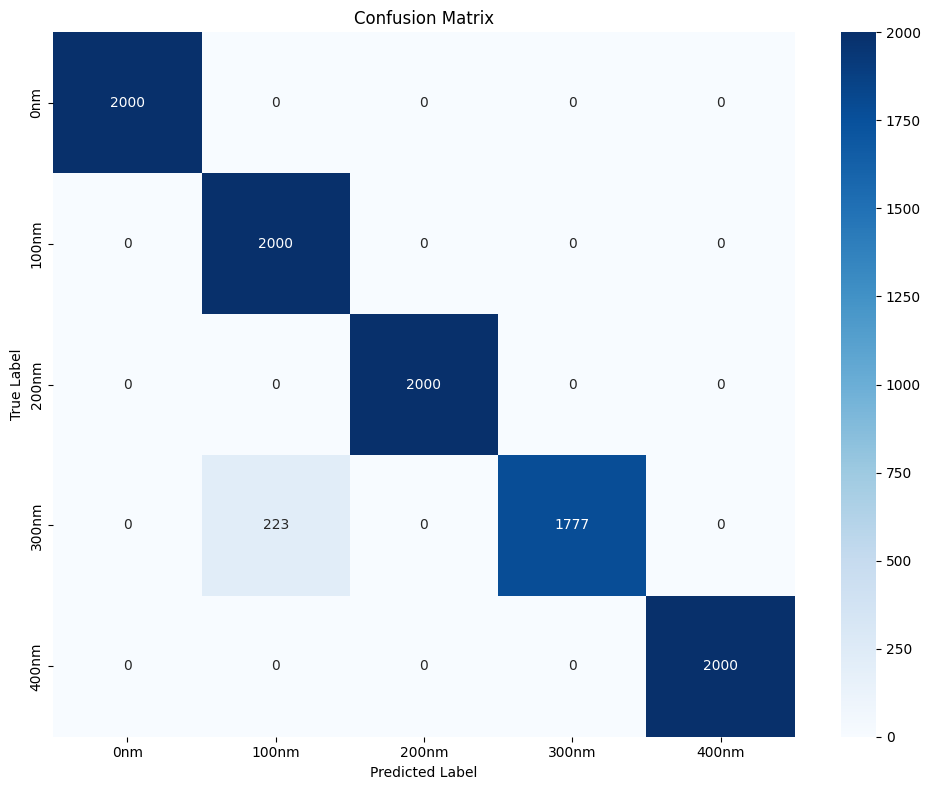

Confusion matrix saved to /content/gdrive/MyDrive/imaging/classification/results/confusion_matrix.png
Confusion matrix saved as NumPy array to /content/gdrive/MyDrive/imaging/classification/results/confusion_matrix.npy


In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 数据集路径
train_data_dir = '/content/gdrive/MyDrive/imaging/classification/train'
test_data_dir = '/content/gdrive/MyDrive/imaging/classification/val'
save_path = '/content/gdrive/MyDrive/imaging/classification/Net.pth'
result_path = '/content/gdrive/MyDrive/imaging/classification/results/training_plot.png'

# 定义数据变换
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5)
])

# 加载训练数据集
train_dataset = ImageFolder(root=train_data_dir, transform=transform)

# 划分训练集和验证集
total_len = len(train_dataset)
train_len = int(0.8 * total_len)  # 80% 作为训练集
val_len = total_len - train_len  # 剩余 20% 作为验证集

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_len, val_len])

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

# 加载测试数据集
test_dataset = ImageFolder(root=test_data_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# 定义卷积模型
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.act3 = nn.Tanh()
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.act4 = nn.Tanh()
        self.pool4 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(256*8*8, 64)
        self.act5 = nn.Tanh()
        self.fc2 = nn.Linear(64, 5)  # 类别数

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = self.pool3(self.act3(self.conv3(out)))
        out = self.pool4(self.act4(self.conv4(out)))
        out = out.view(-1, 256*8*8)
        out = self.act5(self.fc1(out))
        out = self.fc2(out)
        return out

# 初始化模型、损失函数和优化器
model = Net().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 初始化列表用于存储训练和验证的损失和准确率
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# 训练模型
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # 在验证集上评估模型
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch}, Training Loss: {train_loss / len(train_loader)}, Training Accuracy: {train_accuracy}, Validation Loss: {val_loss / len(val_loader)}, Validation Accuracy: {val_accuracy}')

# 在测试集上评估模型
model.eval()
test_loss = 0
correct_test = 0
total_test = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = correct_test / total_test
print(f'Test Loss: {test_loss / len(test_loader)}, Test Accuracy: {test_accuracy}')

# 保存模型
torch.save(model.state_dict(), save_path)

# 绘制训练和验证的损失及准确率图像
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig(result_path)
print(f"Plot saved to {result_path}")

# 计算混淆矩阵
true_labels = []
pred_labels = []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())

# 计算混淆矩阵
cm = confusion_matrix(true_labels, pred_labels)
class_names = train_dataset.dataset.classes  # 获取类别名称

# 绘制混淆矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
confusion_matrix_path = '/content/gdrive/MyDrive/imaging/classification/results/confusion_matrix.png'
plt.savefig(confusion_matrix_path)
plt.show()
print(f"Confusion matrix saved to {confusion_matrix_path}")

# 保存混淆矩阵为NumPy数组
numpy_confusion_matrix_path = '/content/gdrive/MyDrive/imaging/classification/results/confusion_matrix.npy'
np.save(numpy_confusion_matrix_path, cm)
print(f"Confusion matrix saved as NumPy array to {numpy_confusion_matrix_path}")



In [ ]:
import os
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# 检查设备是否可用
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 数据集路径
data_dir = '/content/gdrive/MyDrive/imaging/classification/train'
val_data_dir = '/content/gdrive/MyDrive/imaging/classification/val'  # 验证集路径
save_path = '/content/gdrive/MyDrive/imaging/classification/Net.pth'
result_path = '/content/gdrive/MyDrive/imaging/classification/results/training_plot.png'

# 定义数据变换
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # 修改尺寸
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5)
])

# 加载数据集
dataset = ImageFolder(root=data_dir, transform=transform)

# 划分数据集为训练集和验证集
total_len = len(dataset)
train_len = int(0.7 * total_len)
val_len = int(0.1 * total_len)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, val_len])

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

# 加载验证集作为测试集
test_dataset = ImageFolder(root=val_data_dir, transform=transform)  # 使用val文件夹
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# 定义数据变换
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # 修改尺寸
    transforms.Grayscale(),         # 转为灰度图
    transforms.ToTensor(),          # 转为张量
    transforms.Normalize(mean=0.5, std=0.5)  # 标准化
])

# 定义卷积模型
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.act3 = nn.Tanh()
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.act4 = nn.Tanh()
        self.pool4 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(256*8*8, 64)
        self.act5 = nn.Tanh()
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = self.pool3(self.act3(self.conv3(out)))
        out = self.pool4(self.act4(self.conv4(out)))
        out = out.view(-1, 256*8*8)
        out = self.act5(self.fc1(out))
        out = self.fc2(out)
        return out

# 初始化模型、损失函数和优化器
model = Net().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 初始化列表用于存储训练和验证的损失和准确率
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# 训练模型
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # 在验证集上评估模型
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch}, Training Loss: {train_loss / len(train_loader)}, Training Accuracy: {train_accuracy}, Validation Loss: {val_loss / len(val_loader)}, Validation Accuracy: {val_accuracy}')

# 在独立的测试集上评估模型
model.eval()
test_loss = 0
correct_test = 0
total_test = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = correct_test / total_test
print(f'Test Loss: {test_loss / len(test_loader)}, Test Accuracy: {test_accuracy}')


# 保存模型
torch.save(model.state_dict(), save_path)

# 绘制训练和验证的损失及准确率图像
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig(result_path)
print(f"Plot saved to {result_path}")

# 计算混淆矩阵
cm = confusion_matrix(true_labels, pred_labels)

# 获取类别名称
class_names = train_test_dataset.classes  # 从 train_test_dataset 获取类别名称

# 绘制混淆矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.tight_layout()  # 确保没有内容被裁剪
confusion_matrix_path = '/content/gdrive/MyDrive/imaging/classification/results/confusion_matrix.png' # 修改为实际路径
plt.savefig(confusion_matrix_path)
plt.show()
print(f"Confusion matrix saved to {confusion_matrix_path}")


FileNotFoundError: Found no valid file for the classes 0nm, 10nm, 50nm, 60nm, 70nm, 90nm. Supported extensions are: .jpg, .jpeg, .png, .ppm, .bmp, .pgm, .tif, .tiff, .webp

In [ ]:
print(dataset)

Dataset ImageFolder
    Number of datapoints: 1530
    Root location: /content/gdrive/MyDrive/imaging/classification/input
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               Grayscale(num_output_channels=1)
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )
